# 자동미분을 활용한 방정식

## 1. 텐서그래프 직선 방정식 그려보기

### 1.1. DAG (Directed Acyclic Graph) : 유향 비순환 그래프

---

$y = mx + b$ 와 같은 선형방정식은 유향 비순환 그래프 형태로 표현된다. $y,m,x,b,$는 그래프의 노드를 구성하고, 그래프를 이루는 간선들은 정보, 즉 텐서를 갖고 있다. $*, +$는 각각 그래프에서 opertion 함수로 구현된다.

In [2]:
import torch
import matplotlib.pyplot as plt
import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'

In [3]:
x = torch.tensor([0,1,2,3,4,5,6,7])

y값은 방정식으롷 생성한다. $m = -0.5, b = 2$를 부여한다. 여기에 랜덤 정규분포를 더하여 샘플링 오류를 측정할 수 있도록 한다. 실생활에서 발생되는 케이스들은 대체로 노이즈를 포함하고 있기 때문이다. std 파라미터 값을 키울수록 소음 값이 많아진다.

In [4]:
y = -0.5*x + 2 + torch.normal(mean = torch.zeros(8), std = 0.2) #랜덤 정규분포 소음을 더한다. 소음의 표준편차는 0.2 이다

x를 알츠하이머 약의 투입량, y를 건망증 점수로 보고 이 둘에 대한 상관관계를 살펴보자

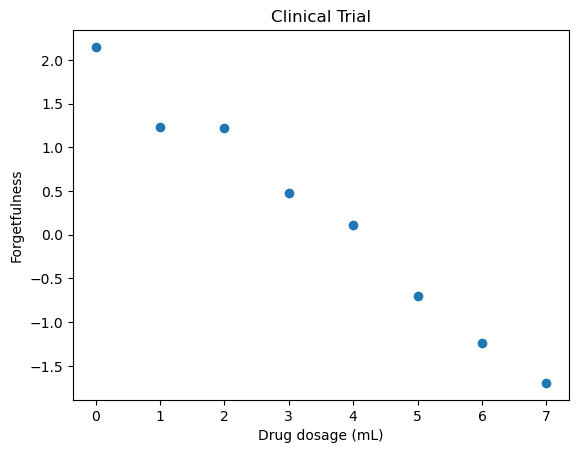

In [5]:
fig, ax = plt.subplots()
plt.title("Clinical Trial")
plt.xlabel("Drug dosage (mL)")
plt.ylabel("Forgetfulness")
ax.scatter(x,y)

매개변수의 초기 불특정 값을 부여해보자. 보통 0에 가깝게 부여한다.

`requires_grad_()`를 True로 설정하여, M 텐서가 만나는 X값 이외의 모든  텐서값에 대해 경사를 추적하도록 하여, y로부터 미분할 수 있도록 한다.

In [7]:
m = torch.tensor([0.9]).requires_grad_()
b = torch.tensor([0.1]).requires_grad_()

In [11]:
def reg_plot(in_x, in_y, in_m, in_b):
    fig, ax = plt.subplots()
    ax.scatter(in_x, in_y)
    
    in_x = in_x.detach().numpy()
    in_y = in_y.detach().numpy()
    in_m = in_m.detach().numpy()
    in_b = in_b.detach().numpy()
    
    x_min, x_max = ax.get_xlim()
    y_min, y_max = in_m*x_min + in_b, in_m*x_max + in_b
    
    ax.set_xlim([x_min, x_max])
    _ = ax.plot([x_min, x_max], [y_min, y_max])

In [10]:
def regg(in_x, in_m, in_b):
    return in_m*in_x + in_b

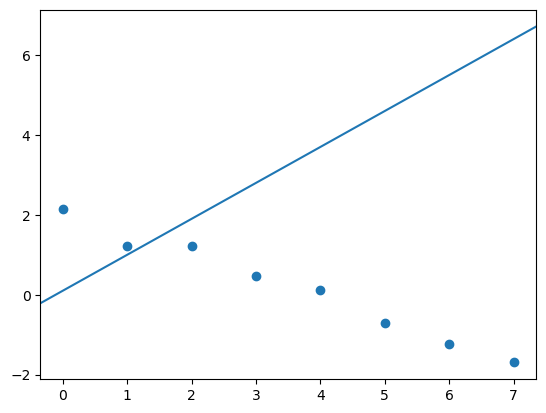

In [12]:
reg_plot(x, y, m, b)

## 2. 머신러닝으로 기울기찾기

### step 1 forward pass

$$
m_1x + b_1 = \hat y ,
 m_n \in M , b_m \in B
$$

추정값을 산출하는 임의의 텐서값을 넣어서 $\hat y$ 를 찾는다.

### step 2 추정치와 실제 값의 비교

$$
c_1 = \hat y_1 - y, c_1 \in C
$$

앞선 과정에서 산출된 $\hat y$값과 실제 $y$ 값의 차이인 $c$를 구한다.

이렇게 되면 아래와 같은 복합함수를 얻을 수 있다.

$$
\hat y = f(x,m,t), c = g(\hat y, y) \newline
c = g(f(x,m,t),y)
$$

### step 3 